In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

ratings_df  = pd.read_pickle("../../data/processed/rating_engage.pkl")
ratings_df = ratings_df[ratings_df["rating"] > 0].reset_index(drop=True)
ratings_df 

,user_id,item_id,rating,item_len
0,0,28833,1.0,123
1,0,29361,5.0,123
2,0,32319,1.0,123
3,0,37990,5.0,123
4,0,40014,5.0,123
...,...,...,...,...
164359,999,69440,5.0,193
164360,999,70383,5.0,193
164361,999,71229,5.0,193
164362,999,71551,5.0,193


In [2]:
unique_user_id = ratings_df['user_id'].unique()
unique_user_id = pd.DataFrame(data={
    'user_id': unique_user_id,
    'mapped_id': pd.RangeIndex(len(unique_user_id)),
})

unique_item_id = ratings_df['item_id'].unique()
unique_item_id = pd.DataFrame(data={
    'item_id': unique_item_id,
    'mapped_id': pd.RangeIndex(len(unique_item_id)),
})

In [3]:
ratings_user_id = pd.merge(ratings_df['user_id'], unique_user_id,
                            left_on='user_id', right_on='user_id', how='left')
ratings_user_id = torch.from_numpy(ratings_user_id['mapped_id'].values)
ratings_item_id = pd.merge(ratings_df['item_id'], unique_item_id,
                            left_on='item_id', right_on='item_id', how='left')
ratings_item_id = torch.from_numpy(ratings_item_id['mapped_id'].values)

In [4]:
edge_index_user_to_item = torch.stack([ratings_user_id, ratings_item_id], dim=0)
edge_index_user_to_item

tensor([[    0,     0,     0,  ...,   999,   999,   999],
        [    0,     1,     2,  ..., 42437,  9920, 14799]])

In [5]:
from torch_geometric.data import HeteroData
import torch_geometric.transforms as T

data = HeteroData()
data["user"].node_id = torch.arange(len(unique_user_id))
data["item"].node_id = torch.arange(len(unique_item_id))
data["user", "rates", "item"].edge_index = edge_index_user_to_item
data = T.ToUndirected()(data)

In [8]:
torch.save(data.to_dict(), "../../data/processed/graph.pkl")

In [10]:
x = HeteroData().from_dict(torch.load("../../data/processed/graph.pkl"))
x

HeteroData(
  user={ node_id=[1000] },
  item={ node_id=[72319] },
  (user, rates, item)={ edge_index=[2, 164364] },
  (item, rev_rates, user)={ edge_index=[2, 164364] }
)

In [18]:
data.metadata()

(['user', 'item'], [('user', 'rates', 'item'), ('item', 'rev_rates', 'user')])

In [19]:
NUM_NEI1, NUM_NEI2 = 100, 50
hidden_channels = 128
num_user = data["user"].num_nodes
num_item = data["item"].num_nodes

In [20]:
transform = T.RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    disjoint_train_ratio=0.3,
    neg_sampling_ratio=2.0,
    add_negative_train_samples=False,
    edge_types=("user", "rates", "item"),
    rev_edge_types=("item", "rev_rates", "user"), 
)
train_data, val_data, test_data = transform(data)

In [21]:
from torch_geometric.loader import LinkNeighborLoader


# Define seed edges:
edge_label_index = train_data["user", "rates", "item"].edge_label_index
edge_label = train_data["user", "rates", "item"].edge_label
train_loader = LinkNeighborLoader(
    data=train_data,
    num_neighbors=[NUM_NEI1, NUM_NEI2],
    neg_sampling_ratio=2.0,
    edge_label_index=(("user", "rates", "item"), edge_label_index),
    edge_label=edge_label,
    batch_size=1024,
    shuffle=True,
)

In [22]:
edge_label_index = val_data["user", "rates", "item"].edge_label_index
edge_label = val_data["user", "rates", "item"].edge_label
val_loader = LinkNeighborLoader(
    data=val_data,
    num_neighbors=[NUM_NEI1, NUM_NEI2],
    edge_label_index=(("user", "rates", "item"), edge_label_index),
    edge_label=edge_label,
    batch_size=3 * 1024,
    shuffle=False,
)

In [23]:
from torch_geometric.nn import GATv2Conv, to_hetero
import sys
sys.path.append("../")
from model import LinkPrediction
from torch import Tensor
import torch.nn as nn

import torch.nn.functional as F

        
model = LinkPrediction(hidden_channels=hidden_channels, num_user=num_user, num_item=num_item)

In [24]:
import tqdm
from sklearn.metrics import roc_auc_score, roc_curve
import torch.nn.functional as F
from copy import deepcopy

best_auc = -float("inf")
model_parameters = deepcopy(model.state_dict())
patience = 3

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Device: '{device}'")
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)


for epoch in range(1, 1000):
    total_loss = total_examples = 0
    for sampled_data in tqdm.tqdm(train_loader):
        optimizer.zero_grad()
        sampled_data.to(device)
        pred = model(sampled_data).squeeze()
        ground_truth = sampled_data["user", "rates", "item"].edge_label
        loss = F.binary_cross_entropy_with_logits(pred, ground_truth)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * pred.numel()
        total_examples += pred.numel()
    print(f"Epoch: {epoch:03d}, Loss: {total_loss / total_examples:.4f}")

    preds = []
    ground_truths = []
    for sampled_data in tqdm.tqdm(val_loader):
        with torch.no_grad():
            sampled_data.to(device)
            preds.append(model(sampled_data).squeeze())
            ground_truths.append(sampled_data["user", "rates", "item"].edge_label)
    pred = torch.cat(preds, dim=0).cpu().numpy()
    ground_truth = torch.cat(ground_truths, dim=0).cpu().numpy()
    auc = roc_auc_score(ground_truth, pred)
    
    print(f"Validation AUC: {auc:.4f}")

    if(auc > best_auc):
        patience_counter=0
        model_parameters=deepcopy(model.state_dict())
        best_auc = auc
    else:
        patience_counter+=1
        if(patience_counter >= patience):
            print("early stop")
            break

Device: 'cuda'


100%|██████████| 39/39 [00:02<00:00, 18.72it/s]


Epoch: 001, Loss: 0.6379


100%|██████████| 17/17 [00:00<00:00, 30.43it/s]


Validation AUC: 0.6134


100%|██████████| 39/39 [00:01<00:00, 24.78it/s]


Epoch: 002, Loss: 0.6328


100%|██████████| 17/17 [00:00<00:00, 27.50it/s]


Validation AUC: 0.6321


100%|██████████| 39/39 [00:01<00:00, 22.72it/s]


Epoch: 003, Loss: 0.6291


100%|██████████| 17/17 [00:00<00:00, 31.68it/s]


Validation AUC: 0.6409


100%|██████████| 39/39 [00:01<00:00, 22.89it/s]


Epoch: 004, Loss: 0.6159


100%|██████████| 17/17 [00:00<00:00, 38.27it/s]


Validation AUC: 0.6776


100%|██████████| 39/39 [00:01<00:00, 23.74it/s]


Epoch: 005, Loss: 0.5984


100%|██████████| 17/17 [00:00<00:00, 47.67it/s]


Validation AUC: 0.6937


100%|██████████| 39/39 [00:01<00:00, 21.87it/s]


Epoch: 006, Loss: 0.5923


100%|██████████| 17/17 [00:00<00:00, 53.20it/s]


Validation AUC: 0.6932


100%|██████████| 39/39 [00:01<00:00, 22.56it/s]


Epoch: 007, Loss: 0.5904


100%|██████████| 17/17 [00:00<00:00, 35.52it/s]


Validation AUC: 0.7025


100%|██████████| 39/39 [00:01<00:00, 23.97it/s]


Epoch: 008, Loss: 0.5883


100%|██████████| 17/17 [00:00<00:00, 27.19it/s]


Validation AUC: 0.6927


100%|██████████| 39/39 [00:01<00:00, 22.22it/s]


Epoch: 009, Loss: 0.5867


100%|██████████| 17/17 [00:00<00:00, 46.40it/s]


Validation AUC: 0.6972


100%|██████████| 39/39 [00:01<00:00, 21.91it/s]


Epoch: 010, Loss: 0.5869


100%|██████████| 17/17 [00:00<00:00, 50.66it/s]

Validation AUC: 0.6975
early stop


## Test

In [25]:
model.load_state_dict(model_parameters)
best_auc

0.7024695412520972

In [26]:
edge_label_index = test_data["user", "rates", "item"].edge_label_index
edge_label = test_data["user", "rates", "item"].edge_label
test_loader = LinkNeighborLoader(
    data=test_data,
    num_neighbors=[NUM_NEI1, NUM_NEI2],
    edge_label_index=(("user", "rates", "item"), edge_label_index),
    edge_label=edge_label,
    batch_size=3 * 1024,
    shuffle=False,
)

In [27]:
from sklearn.metrics import roc_auc_score, roc_curve
preds = []
ground_truths = []
for sampled_data in tqdm.tqdm(test_loader):
    with torch.no_grad():
        sampled_data.to(device)
        preds.append(model(sampled_data).squeeze())
        ground_truths.append(sampled_data["user", "rates", "item"].edge_label)
pred = torch.cat(preds, dim=0).cpu().numpy()
ground_truth = torch.cat(ground_truths, dim=0).cpu().numpy()


100%|██████████| 17/17 [00:00<00:00, 32.24it/s]


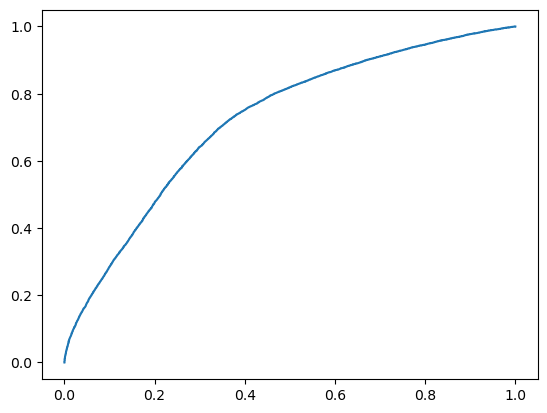

In [28]:
import matplotlib.pyplot as plt

fprs, tprs, th = roc_curve(ground_truth, pred)

plt.plot(fprs, tprs)

In [30]:
torch.save({
    "state_dict": model.cpu().state_dict(), 
    "hidden_channels": hidden_channels, 
    "num_user": num_user,
    "num_item": num_item,
    "num_nei1": NUM_NEI1,
    "num_nei2": NUM_NEI2,
}, "../parameters/linkprediction.pth")